In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (28,14)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Warmup

## 1) Load the Data

In [6]:
# this is a just an example time series

df = pd.read_csv('train_data.csv',parse_dates=True, index_col='date')
df.head()

,temp
date,
1901-01-01,-8.4
1901-01-02,-11.9
1901-01-03,-12.8
1901-01-04,-11.6
1901-01-05,-10.0


## 2) Plot the Data

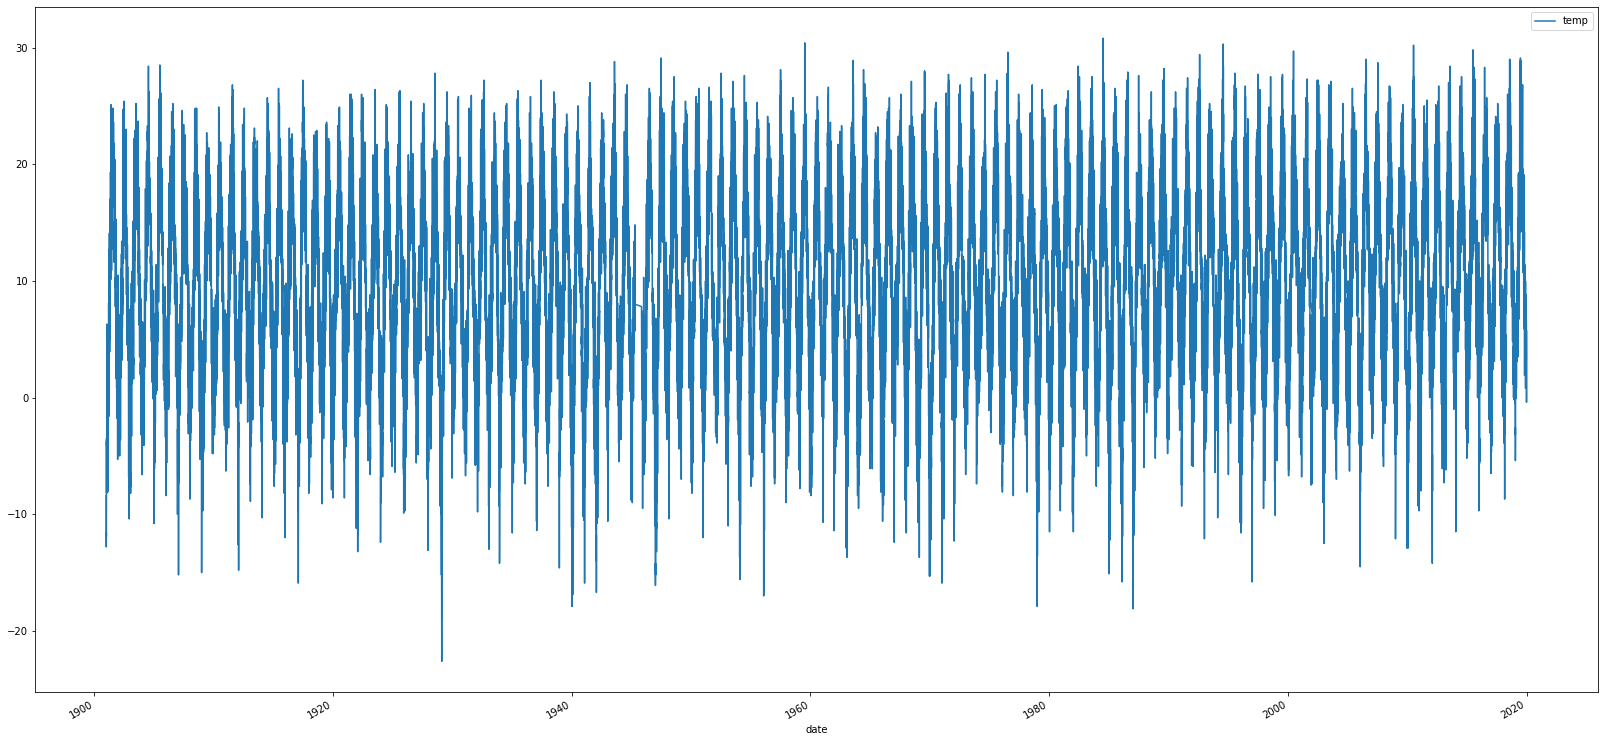

In [7]:
df.plot()
plt.show()

In [8]:
df.mean()

temp    9.455645
dtype: float64

## Is this data stationary ??

In [9]:
# apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [10]:
print_adf(df['temp'])

 
              adf_stats: -17.617226213983933
              p: 3.8540543972029175e-30 
              used lag: 55 
              number of observations: 43213
            
              CI 99%: -3.4305013361370524
              CI 95%: -2.861606887233037
              CI 90%: -2.5668056019022885
              information criterion (AIC): 195764.43598259357
            


### We then conclude from the results of the adf test that the time series we have is stationary

## 3) Inspect the Partial Autocorrelation (Box-Jenkins-Methodology)

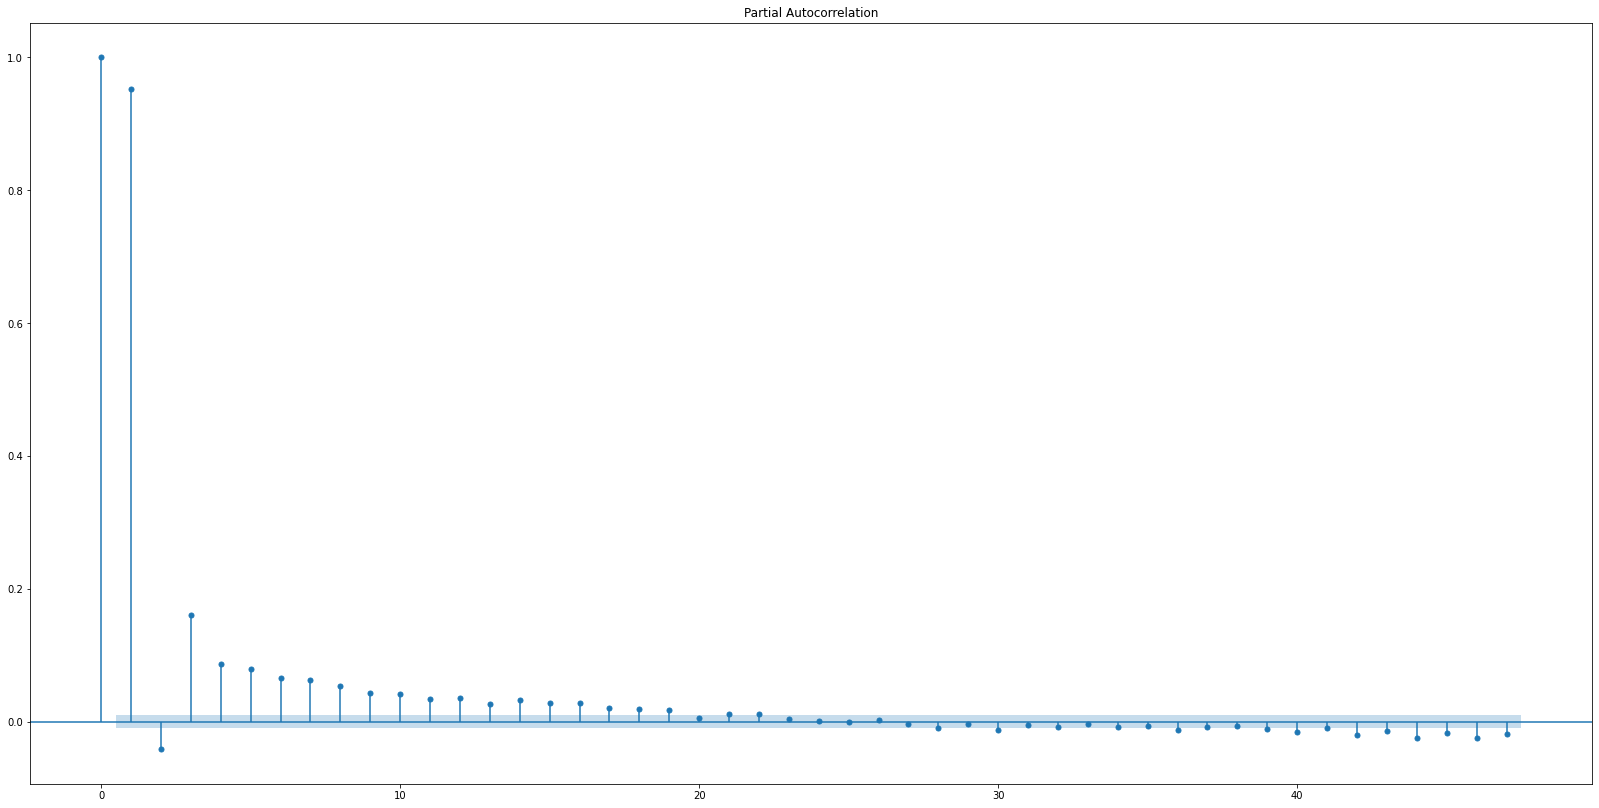

In [11]:
# Plot the partial autocorrelation function
plot_pacf(df['temp']);

plt.show()

## Q: Inspecting the pacf plot we choose to include ? lags into our model ? How can we be additionally sure ?

In [9]:
# Use ar_select_order - brute force method that tries different models and takes the best one

order = ar_select_order(df, maxlag=20, old_names=False)

In [10]:
# How many lags does ar_select_order suggest?

order.ar_lags

array([1, 2, 3, 4])

## 4) Build a AR model with the right number of lags

Everything points us towards using 4 lags for our model

In [11]:
# Fit a statsmodels AutoReg model

ar_model = AutoReg(df['remainder'], lags=4, old_names=False).fit()

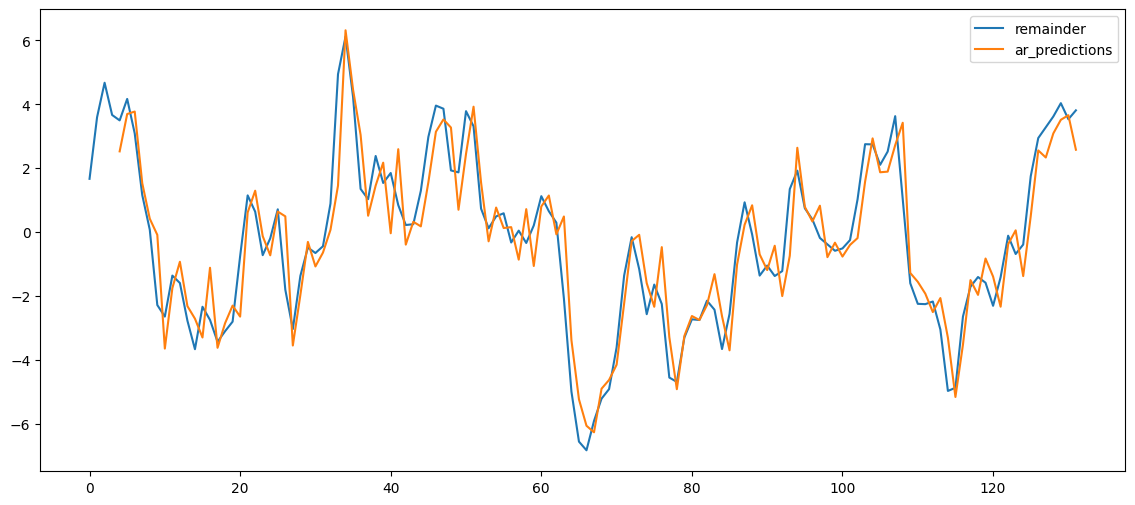

In [12]:
# Plot the prediction

df.plot()
plt.plot(ar_model.predict(), label='ar_predictions')
plt.legend()
plt.show()

# Looks good, can we do better?

## ARIMA - Autoregressive Integrated Moving Average

With the AR model we found a quite decent model for our data. The question is, can we do even better? 

One way we might be able to improve our model is by including a **Moving Average part (MA)** into the model

Simply speaking the **MA** part is just a different way of modeling time dependence. Instead of using past values of the variable itself we will **use past prediction errors to predict the future**. Mathematically this looks like:

### 1) AR(p)

The $AR(p)$ part is just an autoregressive part of the model where *p* denotes the number of lags to include.

### 2) I(d)

The $I(d)$ part is just the part where the model is detrended. *d* determines which order of differencing should be applied to the original time series data before modelling the AR and MA parts

If the data is stationary, then $d = 0$

### 3) MA(q)

This is the new part that we have not seen before. Instead of regressing on past lags, the Moving Average approach regresses on past errors:

**MA(1):** $\hat{y_{t+1}} = b + \phi*\epsilon_{t}$

where $\epsilon_{t} = \hat{y_{t}} - y_{t} $

or adding more features (lags):

**MA(2):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + \phi_2*\epsilon_{t-1}$

or adding more features (lags):

**MA(q):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + ... + \phi_q*\epsilon_{t-q-1}$


### How do we determine the order of the MA term q?

Instead of looking at the partial autocorrelation as was the case for the AR model we can look at the autocorrelation between observations $y_t$ and $y_{t-h}$.

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

**What does the Box-Jenkins method say here?**

#### Value of q

The value of q is found from the autocorrelations plot as follows:


- If the autocorrelations cut off after a few lags, the last lag with a large value would be the estimated value of q
- If the autocorrelations do not cut off, but rather decay gradually, you either have an autoregressive model (q=0) or an ARIMA model with a positive p and q

[source](https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf)

## I know that the data follows an ARIMA (1,0,1) process 

This means the process has an AR(1), MA(1) and I(0) component, i.e. **ARIMA (1,0,1)**

In [ ]:
# Fit an ARIMA model
arima_model = ARIMA(df['remainder'], order=(1,0,1)).fit()

# order defines (#of AR lags, I, #of MA lags); (p,d,q)
# (1,0,1) - means that we have 1 AR lag and 1 MA lag

$$
\hat{y_{t+1}} = b + w_1 * y_t + \phi_1 * \epsilon_t
$$

In [ ]:
# Plot all time series
df.plot()
plt.plot(ar_model.predict(), label='ar_predictions')
plt.plot(arima_model.predict(), label='arima_predictions')
plt.legend()
plt.show()

## How do I determine which model to choose?


1. test stationarity
2. plot pacf and acf
3. determine possible ranges for p and q values
4. Fit all possible combinations (p,0,q) models and compare them. Models with lower AIC/BIC score are better at explaining the data we have

### What do AIC and BIC mean ? https://www.youtube.com/watch?v=McEN54l3EPU

In [ ]:
# Plot the autocorrelation between lags
plot_acf(df);

plt.show()

In [ ]:
# Plot the partial autocorrelation between lags
plot_pacf(df);

plt.show()

Analogous to the plot of the partial autocorrelation for the AR part of the model, the plot of the autocorrelation function gives us an idea which lag to chose for the MA. If there is no clear cutoff this could mean

- That the time series is better modelled by a pure AR model
- That the time series is best modelled by a model including AR and MA terms (ARIMA)

### How to read the ACF-plot and the PACF-plot

Interpretation:

- If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot.

### **AR process**

ACF-Plot AR(1)             |  PACF-Plot AR(1)
:-------------------------:|:-------------------------:
![](./images/acf_ar.png)   |  ![](./images/pacf_ar.png)

- If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot.

---

### **MA process**

ACF-Plot MA(1)             |  PACF-Plot MA(1)
:-------------------------:|:-------------------------:
![](./images/acf_ma.png)   |  ![](./images/pacf_ma.png)

- If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually you would use an iterrative approach and try different combinations to find the best model. (eg. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

---

### **ARIMA process**

ACF-Plot ARIMA(1,0,1)      |  PACF-Plot ARIMA(1,0,1)
:-------------------------:|:-------------------------:
![](./images/acf_arima.png)|  ![](./images/pacf_arima.png)

## Other option: brute force; run multiple models with several combinations of p and q and choose the best one where best is usuall measured in terms of AIC

In [ ]:
#pip install pmdarima

In [13]:
from pmdarima.arima import auto_arima

In [14]:
# ARIMA(p,d,q)

# p = number of AR lags
# q = number of MA lags
# d = the order of integration

auto_arima_model = auto_arima(df['remainder'], start_p=0, start_q=0, max_p=10, max_q=10)


In [15]:
auto_arima_model

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Integrated(I)

Integrating a time series is an alternative way to model a trend of the time series.

if $y_t$ is our time series and it has a trend component, then to de-trend the series and make it stationary, we can difference it ==> $y_t - y_{t-1}$ would be the time series differentiated by order 1

Then to be able to get $y_t$ from the stationary de-trended series, we would need to **integrate** once, i.e. $I(1)$

In [24]:
import numpy as np

In [25]:
df_i = pd.DataFrame({'y': range(101)})
df_i.head()

,y
0,0
1,1
2,2
3,3
4,4


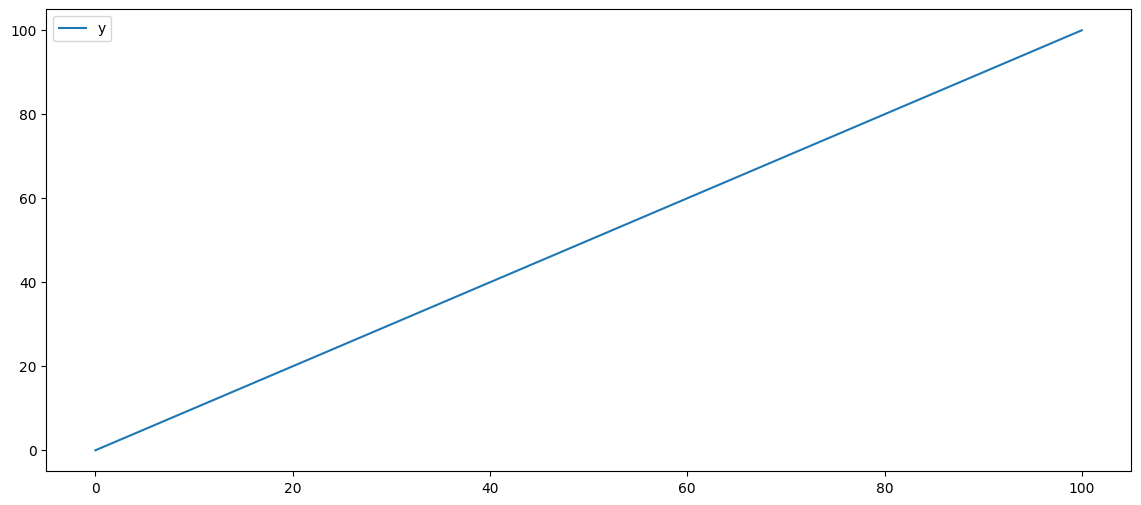

In [26]:
df_i.plot()

plt.show()

In [27]:
# Let's first order differentiate this time series data
df_i['y_diff'] = df_i.y - df_i.y.shift() # y_t - y_{t-1}
df_i['y_difference'] = df_i['y'].diff()
df_i.head()

,y,y_diff
0,0,NaN
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


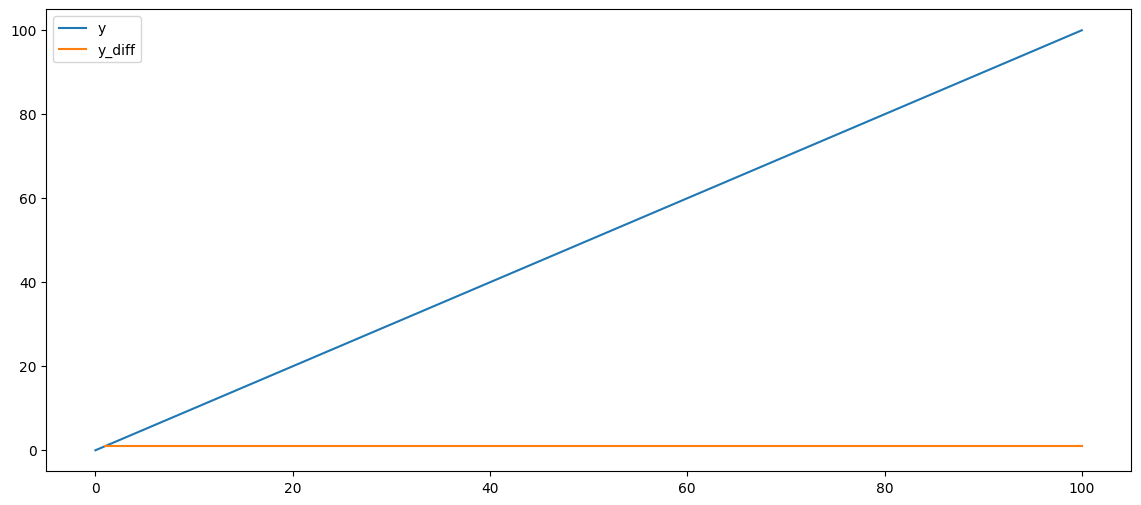

In [28]:
df_i.plot()

plt.show()

# How to integrate the knowledge into the project

In [12]:
df_train = pd.read_csv('train_data.csv', parse_dates=True, index_col=0)
df_train.head()

,temp
date,
1901-01-01,-8.4
1901-01-02,-11.9
1901-01-03,-12.8
1901-01-04,-11.6
1901-01-05,-10.0


In [43]:
# what to do if the time seris has a trend ?

#flights_train['diff1'] = flights_train['passengers'].diff()

#flights_train.head()

In [44]:
# we keep differencing until the time series is stationary

# print_adf(flights_train['diff1'].dropna())

### Note: use the differenced stationary version of the time series to plot ACF and PACF!!!!

### step 1: Let's look at the remainder acf and pacf plots (of the stationary remainder signal!!)

In [13]:
# I save the remainder from before in a csv file

remainder = pd.read_csv('remainder.csv', index_col=0, parse_dates=True)
remainder.head()

,remainder
date,
1901-01-01,-7.697368
1901-01-02,-11.251414
1901-01-03,-12.202083
1901-01-04,-11.038184
1901-01-05,-9.418339


In [14]:
print_adf(remainder)

 
              adf_stats: -28.614493298619827
              p: 0.0 
              used lag: 32 
              number of observations: 43236
            
              CI 99%: -3.4305012556268797
              CI 95%: -2.8616068516502238
              CI 90%: -2.5668055829625547
              information criterion (AIC): 196800.0616468771
            


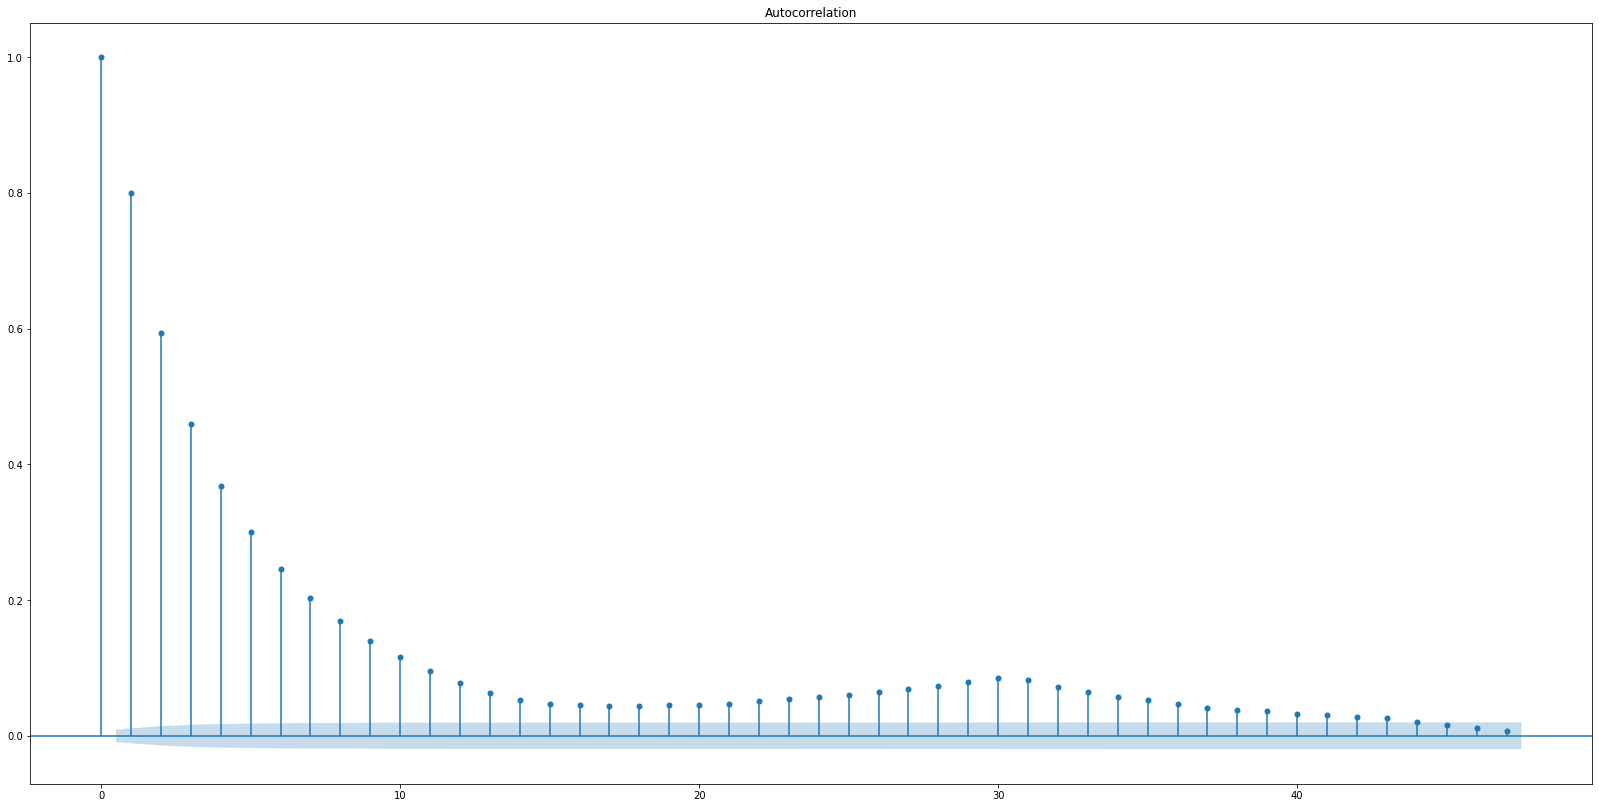

In [15]:
plot_acf(remainder);

plt.show()

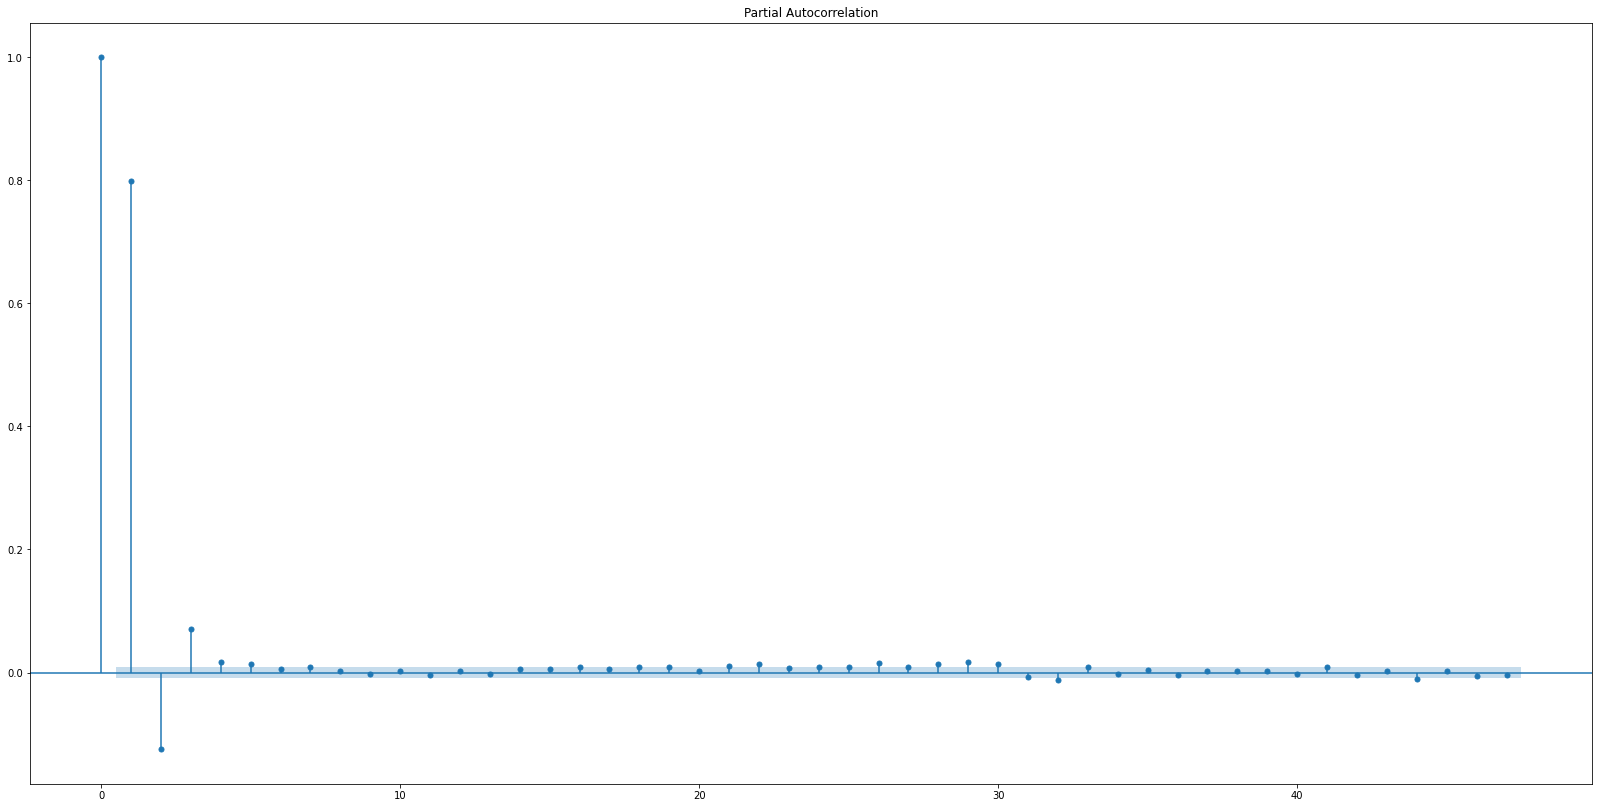

In [16]:
plot_pacf(remainder);

plt.show()

### step 2: Attempt multiple models and choose the best

In [18]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(df_train['temp'], start_p=0, start_q=0, max_p=15, max_q=15, max_d=1)


In [19]:
auto_arima_model

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [20]:
# fit and ARIMA (3,1,4) model

model = ARIMA(df_train['temp'], order=(4,1,1)).fit()

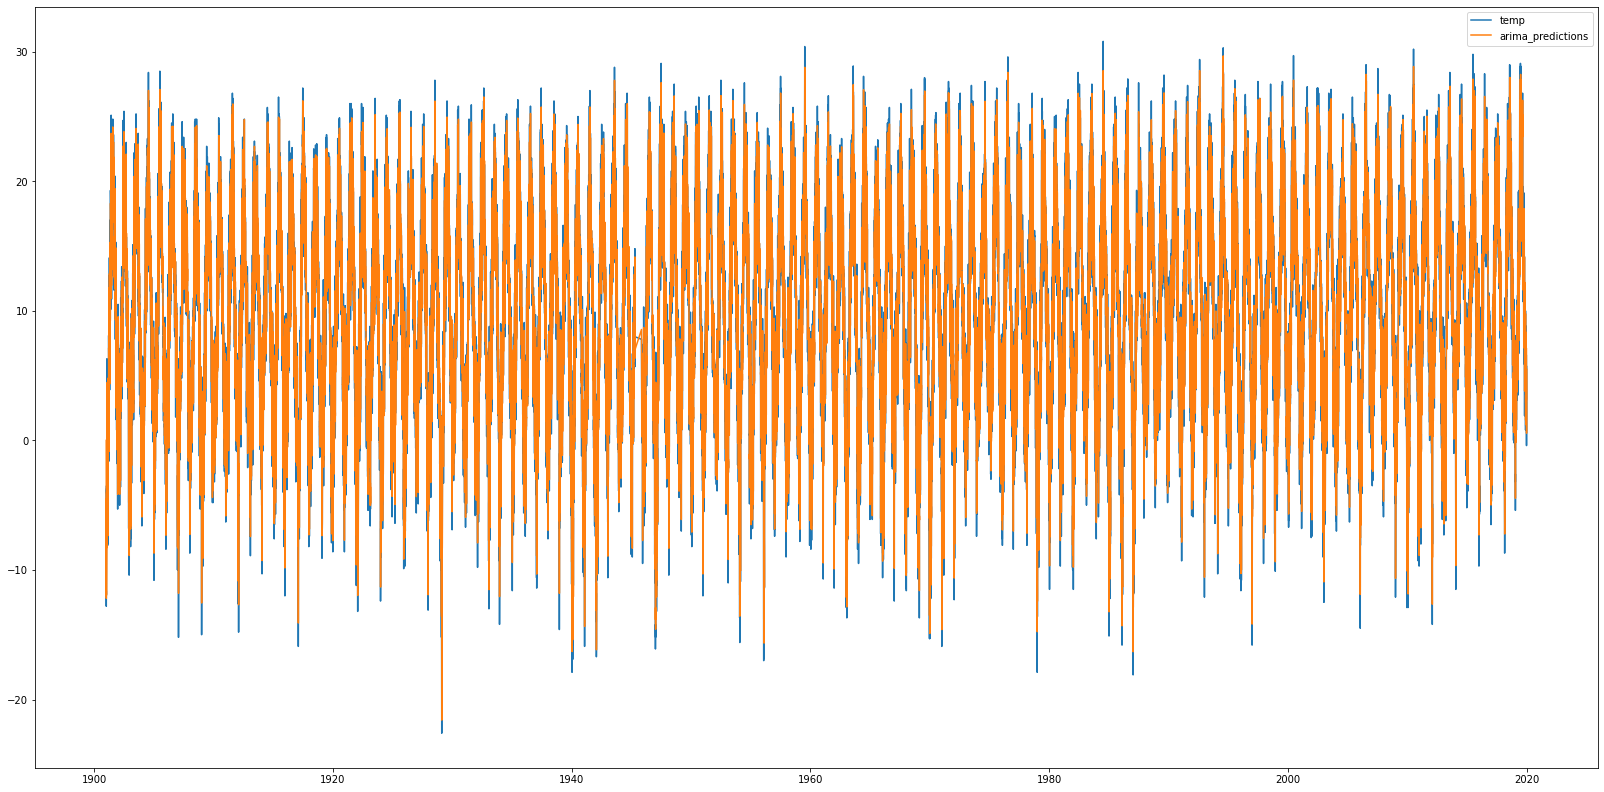

In [21]:
plt.plot(df_train['temp'], label='temp')
plt.plot(model.predict(), label='arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend()

plt.show()

### How about the seasonality ??

In [22]:
seasonal_dummies = pd.get_dummies(df_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(df_train.index)

df_train = df_train.join(seasonal_dummies)

In [23]:
seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
1901-01-01,0,0,0,0,0,0,0,0,0,0,0
1901-01-02,0,0,0,0,0,0,0,0,0,0,0
1901-01-03,0,0,0,0,0,0,0,0,0,0,0
1901-01-04,0,0,0,0,0,0,0,0,0,0,0
1901-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1


In [24]:
df_train.head()

,temp,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
1901-01-01,-8.4,0,0,0,0,0,0,0,0,0,0,0
1901-01-02,-11.9,0,0,0,0,0,0,0,0,0,0,0
1901-01-03,-12.8,0,0,0,0,0,0,0,0,0,0,0
1901-01-04,-11.6,0,0,0,0,0,0,0,0,0,0,0
1901-01-05,-10.0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# exog in statsmodels ARIMA is the same as X in any sklearn model

model_season = ARIMA(df_train['temp'], order=(4,1,1), exog=seasonal_dummies).fit()


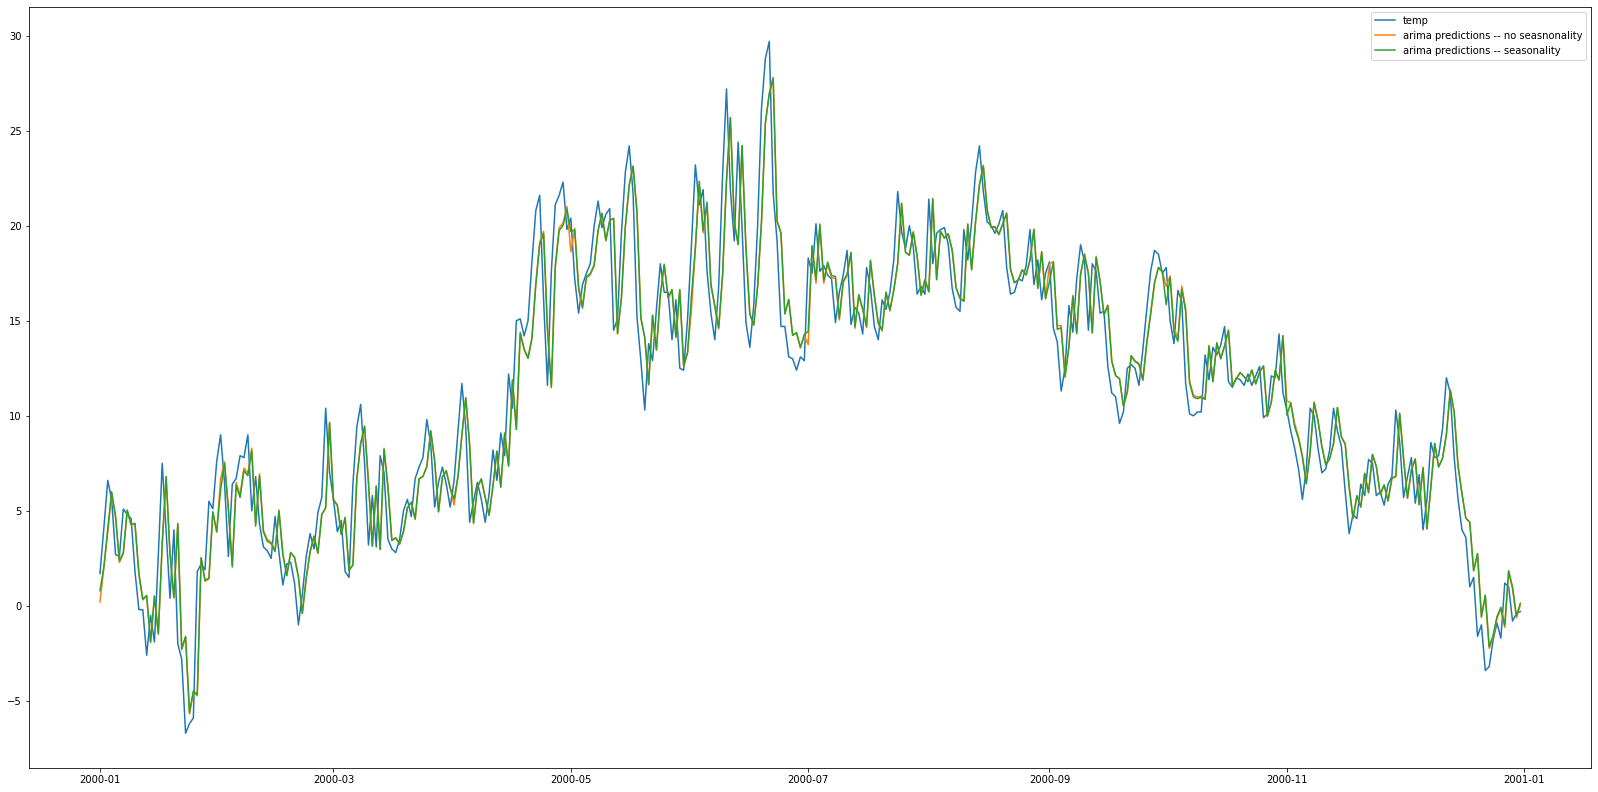

In [26]:
plt.plot(df_train.loc['2000']['temp'], label='temp')
plt.plot(model.predict().loc['2000'],
         label='arima predictions -- no seasnonality')
plt.plot(model_season.predict().loc['2000'],
         label='arima predictions -- seasonality')
plt.legend()

plt.show()


### so how can we check which model is better on training data ?

In [28]:
import numpy as np
rmse_no_seasonality = np.sqrt(mean_squared_error(df_train['temp'], model.predict()))

rmse_seasonality = np.sqrt(mean_squared_error(df_train['temp'], model_season.predict()))



In [29]:
rmse_no_seasonality, rmse_seasonality

(2.3408516020751127, 2.3374015526352743)

## so how can we check model behavior on unseen data ? How can we use the model to forecast ?

In [30]:
df_train.tail()

,temp,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2019-12-27,2.8,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0.8,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,-0.4,0,0,0,0,0,0,0,0,0,0,1
2019-12-30,4.7,0,0,0,0,0,0,0,0,0,0,1
2019-12-31,5.7,0,0,0,0,0,0,0,0,0,0,1


### a) One step out-of-sample prediction

In [31]:
model.forecast()

43269    5.298857
dtype: float64

In [51]:
#model_season.forecast()

In [33]:
seasonal_dummies.iloc[0]

month_2     0
month_3     0
month_4     0
month_5     0
month_6     0
month_7     0
month_8     0
month_9     0
month_10    0
month_11    0
month_12    0
Name: 1901-01-01 00:00:00, dtype: uint8

In [34]:
model_season.forecast(exog=seasonal_dummies.iloc[0])

43269    5.869296
dtype: float64

### b) Multiple steps out-of-sample predictions

In [47]:
model.predict(start=43269, end=43269+365)

43269    5.298857
43270    5.030633
43271    4.886722
43272    4.789338
43273    4.726275
           ...   
43630    4.627858
43631    4.627858
43632    4.627858
43633    4.627858
43634    4.627858
Name: predicted_mean, Length: 366, dtype: float64

In [41]:
a = seasonal_dummies.loc['1904']

In [43]:
model_season.predict(start=43269, end=43269+365,
                     exog=a)


43269    5.869296
43270    5.613194
43271    5.481562
43272    5.392275
43273    5.332201
           ...   
43630    4.671372
43631    4.671372
43632    4.671372
43633    4.671372
43634    4.671372
Name: predicted_mean, Length: 366, dtype: float64

In [44]:
test_seasonality_pred

NameError: name 'test_seasonality_pred' is not defined

In [45]:
df_test = pd.read_csv('test_data.csv', parse_dates=True, index_col=0)


In [46]:
df_test

,temp
date,
2020-01-01,1.7
2020-01-02,0.5
2020-01-03,4.5
2020-01-04,3.9
2020-01-05,1.2
...,...
2020-12-27,1.7
2020-12-28,3.0
2020-12-29,2.3


In [48]:
# add predictions from both models

df_test['predictions'] = model.predict(start=43269, end=43269+365).values

df_test['predictions_season'] = model_season.predict(
    start=43269, end=43269+365, exog=a).values


In [49]:
df_test

,temp,predictions,predictions_season
date,,,
2020-01-01,1.7,5.298857,5.869296
2020-01-02,0.5,5.030633,5.613194
2020-01-03,4.5,4.886722,5.481562
2020-01-04,3.9,4.789338,5.392275
2020-01-05,1.2,4.726275,5.332201
...,...,...,...
2020-12-27,1.7,4.627858,4.671372
2020-12-28,3.0,4.627858,4.671372
2020-12-29,2.3,4.627858,4.671372


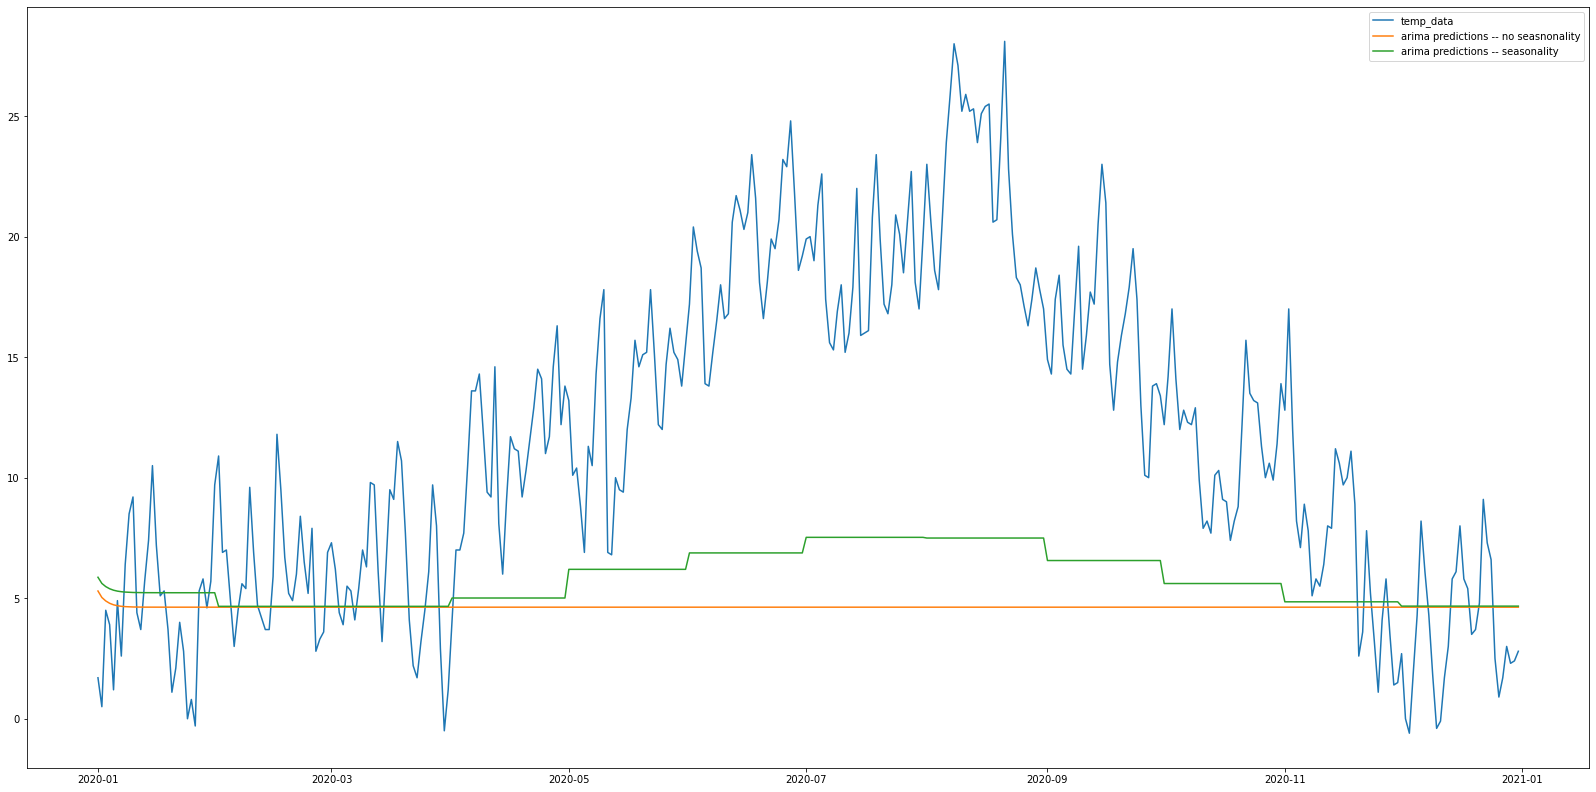

In [52]:
plt.plot(df_test['temp'], label='temp_data')
plt.plot(df_test['predictions'], label='arima predictions -- no seasnonality')
plt.plot(df_test['predictions_season'], label='arima predictions -- seasonality')
plt.legend()

plt.show()

In [71]:
model.predict(start='1960-01-01', end='1961-12-01').iloc[-1]

1960-01-01    349.275902
1960-02-01    344.023922
1960-03-01    367.322781
1960-04-01    383.882705
1960-05-01    402.901267
1960-06-01    413.188758
1960-07-01    415.314867
1960-08-01    407.674189
1960-09-01    393.235382
1960-10-01    375.676477
1960-11-01    359.782152
1960-12-01    349.525692
1961-01-01    347.375116
1961-02-01    353.571116
1961-03-01    366.213400
1961-04-01    381.799129
1961-05-01    396.200293
1961-06-01    405.744944
1961-07-01    408.150762
1961-08-01    403.060944
1961-09-01    392.065750
1961-10-01    378.219938
1961-11-01    365.200728
1961-12-01    356.336105
Freq: MS, Name: predicted_mean, dtype: float64